# Deep Learning for Availability Prediction

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import geopandas
import json
from shapely.geometry import shape
from h3 import h3
from vincenty import vincenty 
from scipy import stats
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


## Starting with Hexagon size = 7

In [4]:
df_availability = pd.read_csv('Data/availability_SVR.csv') 

In [5]:
features = ["time_basket", "month", "center_x", "center_y", "weekend", 
            "distance_next_station", "distanceToCentralStation", "distanceToUniversity", "urban_fabric", "industry_commercial", 
            "green_urban_area"]

In [6]:
# feature selection 
X = df_availability[features]
y = df_availability[["available_bikes"]]
X_train , X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)

In [7]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))    
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae','mse'])
    return model

In [8]:
model = build_model()
scaler = StandardScaler()
history = model.fit(scaler.fit_transform(X_train),y_train,epochs=50,batch_size=128,verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
159400/159400 [==============================] - 2s 14us/step - loss: 12226.6493 - mae: 57.8003 - mse: 12226.6523
Epoch 2/50
159400/159400 [==============================] - 2s 13us/step - loss: 2038.6522 - mae: 33.9633 - mse: 2038.6530
Epoch 3/50
159400/159400 [==============================] - 2s 13us/step - loss: 1174.0745 - mae: 25.8247 - mse: 1174.0743
Epoch 4/50
159400/159400 [==============================] - 2s 12us/step - loss: 851.9334 - mae: 21.2844 - mse: 851.9329
Epoch 5/50
159400/159400 [==============================] - 2s 12us/step - loss: 672.3406 - mae: 18.2384 - mse: 672.3405
Epoch 6/50
159400/159400 [==============================] - 2s 12us/step - loss: 566.4864 - mae: 16.3909 - mse: 566.4864
Epoch 7/50
159400/159400 [==============================] - 2s 12us/step - loss: 502.4033 - mae: 15.1623 - mse: 502.4031
Epoch 8/50
159400/159400 

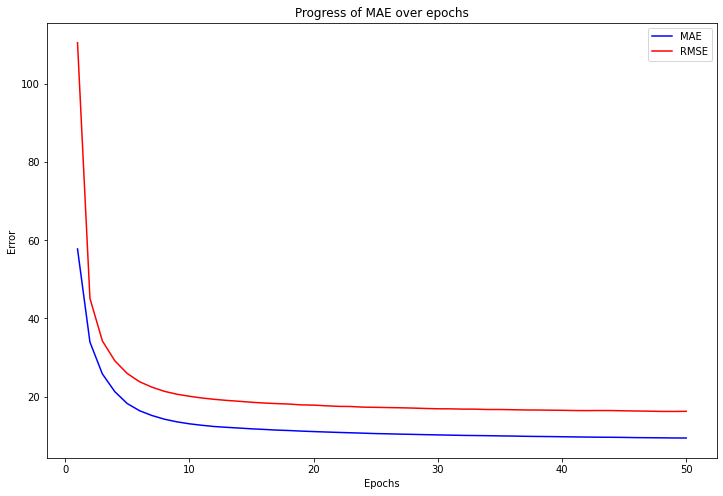

In [9]:
plt.figure(figsize=(12,8))
mae = history.history['mae']
mse = history.history["mse"]
epochs = range(1, len(mae) + 1)
plt.plot(epochs, mae, 'b', label='MAE')
plt.plot(epochs, np.sqrt(mse), 'r', label="RMSE")
plt.title('Progress of MAE over epochs')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

In [10]:
pred = model.predict(scaler.fit_transform(X_train))
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("RMSE ", np.sqrt(mean_squared_error(y_train,pred)))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(scaler.fit_transform(X_test))
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("RMSE ", np.sqrt(mean_squared_error(y_test,pred)))
print("R2 ",r2_score(y_test,pred))

ON TRAINING DATA:
MAE  11.814132049174574
MSE  440.5041797763436
RMSE  20.988191436527913
R2  0.9897235524621274


ON TEST DATA:
MAE  11.947523265695324
MSE  443.44990746654486
RMSE  21.05825034200479
R2  0.9895080507279945


##### In comparison to the SVR this first NN returns much better results. Furthermore the NN isn't overfitted. 

In [11]:
# increase epochs 
model = build_model()
history = model.fit(scaler.fit_transform(X_train),y_train,epochs=100,batch_size=128,verbose=0)
pred = model.predict(scaler.fit_transform(X_train))
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(scaler.fit_transform(X_test))
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

ON TRAINING DATA:
MAE  9.171050402959587
MSE  247.61548694760137
R2  0.9942234201671508


ON TEST DATA:
MAE  9.201514095015192
MSE  244.79182610769084
R2  0.9942082670929021


In [14]:
# use adam as optimizer
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae','mse'])
    return model

model = build_model()

history = model.fit(scaler.fit_transform(X_train),y_train,epochs=50,batch_size=128,verbose=0)

pred = model.predict(scaler.fit_transform(X_train))
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(scaler.fit_transform(X_test))
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

ON TRAINING DATA:
MAE  9.894160987443875
MSE  266.5127286479136
R2  0.9937825696103131


ON TEST DATA:
MAE  9.800591622705577
MSE  258.02011890603643
R2  0.9938952879386423


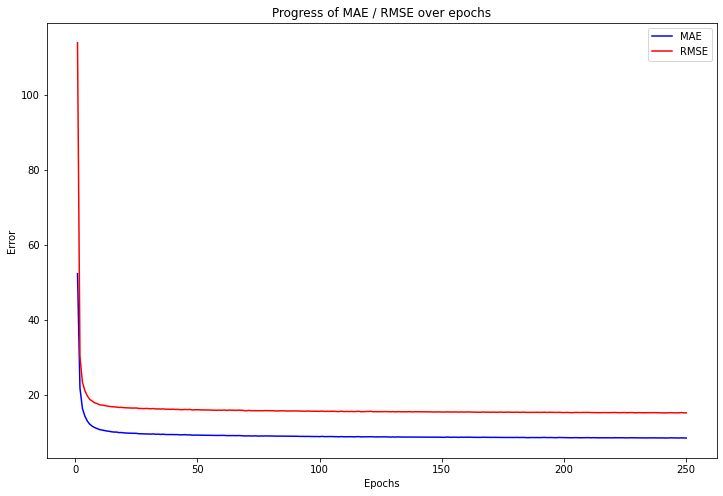

ON TRAINING DATA:
MAE  8.297172191510283
MSE  221.87949981709434
R2  0.9948238106599636


ON TEST DATA:
MAE  8.402641917009776
MSE  219.61481625539798
R2  0.9948039508572764


In [15]:
# drop one hidden layer and see what happens
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(32, activation='relu'))    
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae','mse'])
    return model

model = build_model()
# increase number of epochs 
# decrease batch_size
history = model.fit(scaler.fit_transform(X_train),y_train,epochs=250,batch_size=64,verbose=0)

plt.figure(figsize=(12,8))
mae = history.history['mae']
mse = history.history["mse"]
epochs = range(1, len(mae) + 1)
plt.plot(epochs, mae, 'b', label='MAE')
plt.plot(epochs, np.sqrt(mse), 'r', label="RMSE")
plt.title('Progress of MAE / RMSE over epochs')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

pred = model.predict(scaler.fit_transform(X_train))
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(scaler.fit_transform(X_test))
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

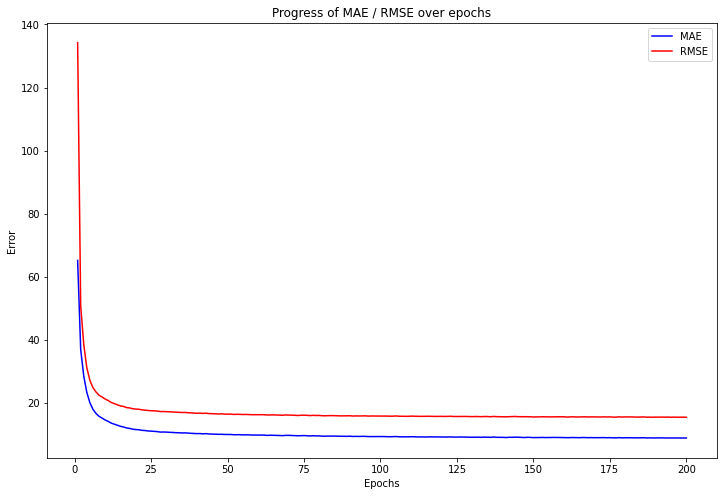

ON TRAINING DATA:
MAE  9.244865880821326
MSE  247.80295452791216
R2  0.9942190467676633


ON TEST DATA:
MAE  9.283940153975076
MSE  243.02011549636774
R2  0.9942501854641673


In [16]:
# drop one hidden layer and see what happens
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(32, activation='relu'))    
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae','mse'])
    return model

model = build_model()

history = model.fit(scaler.fit_transform(X_train),y_train,epochs=200,batch_size=128,verbose=0)

plt.figure(figsize=(12,8))
mae = history.history['mae']
mse = history.history["mse"]
epochs = range(1, len(mae) + 1)
plt.plot(epochs, mae, 'b', label='MAE')
plt.plot(epochs, np.sqrt(mse), 'r', label="RMSE")
plt.title('Progress of MAE / RMSE over epochs')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

pred = model.predict(scaler.fit_transform(X_train))
print("ON TRAINING DATA:")
print("MAE ", mean_absolute_error(y_train,pred))
print("MSE ", mean_squared_error(y_train,pred))
print("R2 ", r2_score(y_train,pred))
print("\n")

pred = model.predict(scaler.fit_transform(X_test))
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

# Optimizing Hyperparameters with GridSearch

#### Epochs, Batch Size and Optimizer

###### previous results  with ... 
epochs: 50 <br>
batch size: 128 <br>
optimizer: Adam <br>

ON TEST DATA: <br>
MAE  9.800591622705577 <br>
MSE  258.02011890603643 <br> 
R2  0.9938952879386423 <br>

Although the results are already very good, we will see if the hyper parameters can be optimized with GridSearch even more.

In [7]:
# Function to build the model, required for KerasClassifier
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))    
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=build_model, verbose=0)

# search for best batch size and number of epochs 
# define the grid search parameters
batch_size = [32,64,128,256]
epochs = [20,50,100,150]

param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

# run grid search 
grid_result = grid.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Best: 0.028189 using {'batch_size': 256, 'epochs': 20}
0.008726 (0.001880) with: {'batch_size': 32, 'epochs': 20}
0.005726 (0.001750) with: {'batch_size': 32, 'epochs': 50}
0.004984 (0.001618) with: {'batch_size': 32, 'epochs': 100}
0.006473 (0.002405) with: {'batch_size': 32, 'epochs': 150}
0.006772 (0.002116) with: {'batch_size': 64, 'epochs': 20}
0.004440 (0.002296) with: {'batch_size': 64, 'epochs': 50}
0.006688 (0.002924) with: {'batch_size': 64, 'epochs': 100}
0.005849 (0.000615) with: {'batch_size': 64, 'epochs': 150}
0.008028 (0.001270) with: {'batch_size': 128, 'epochs': 20}
0.006785 (0.001305) with: {'batch_size': 128, 'epochs': 50}
0.008014 (0.003481) with: {'batch_size': 128, 'epochs': 100}
0.003228 (0.002516) with: {'batch_size': 128, 'epochs': 150}
0.028189 (0.030559) with: {'batch_size': 256, 'epochs': 20}
0.010074 (0.004356) with: {'batch_size': 256, '

Gridsearch has found the optimal batch size = 256 and the optimal number of epochs = 20.
On the basis of these two hyperparameters we are looking for the optimal optimizer using GridSearch.

In [8]:
# Function to create model, required for KerasClassifier
def build_model(optimizer="adam"):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))    
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae','accuracy'])
    return model

model = KerasClassifier(build_fn=build_model, epochs=20, batch_size=256, verbose=0)

# define the grid search parameters for optimizer 
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)
grid_result = grid.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.008686 using {'optimizer': 'RMSprop'}
0.000000 (0.000000) with: {'optimizer': 'SGD'}
0.008686 (0.003401) with: {'optimizer': 'RMSprop'}
0.003122 (0.003254) with: {'optimizer': 'Adagrad'}
0.003641 (0.002142) with: {'optimizer': 'Adadelta'}
0.004993 (0.003077) with: {'optimizer': 'Adam'}
0.005621 (0.001776) with: {'optimizer': 'Adamax'}
0.008678 (0.002418) with: {'optimizer': 'Nadam'}


GridSearch has found the optimal optimizer = 'RMSprop'. In the following model we use the found hyper parameters.

In [9]:
scaler = StandardScaler()

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='RMSprop', loss='mse', metrics=['mae','mse']) #set the new optimizer 
    return model

model = build_model()

# use results of grid search for epochs and batch size 
history = model.fit(scaler.fit_transform(X_train),y_train,epochs=20,batch_size=256,verbose=0)

pred = model.predict(scaler.fit_transform(X_test))
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

ON TEST DATA:
MAE  18.333713930113127
MSE  704.8108128273067
R2  0.9833242962281982


In [11]:
scaler = StandardScaler()

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='RMSprop', loss='mse', metrics=['mae','mse']) #set the new optimizer 
    return model

model = build_model()

# use results of grid search for epochs and batch size 
history = model.fit(scaler.fit_transform(X_train),y_train,epochs=50,batch_size=256,verbose=0)

pred = model.predict(scaler.fit_transform(X_test))
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

ON TEST DATA:
MAE  11.135502896821578
MSE  339.7693353547794
R2  0.9919611154028839


In [12]:
scaler = StandardScaler()

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='RMSprop', loss='mse', metrics=['mae','mse']) #set the new optimizer 
    return model

model = build_model()

# use results of grid search for epochs and batch size 
history = model.fit(scaler.fit_transform(X_train),y_train,epochs=50,batch_size=128,verbose=0)

pred = model.predict(scaler.fit_transform(X_test))
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

ON TEST DATA:
MAE  8.682679934870016
MSE  231.7640926533381
R2  0.994516501047247


In [13]:
scaler = StandardScaler()

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='RMSprop', loss='mse', metrics=['mae','mse']) #set the new optimizer 
    return model

model = build_model()

# use results of grid search for epochs and batch size 
history = model.fit(scaler.fit_transform(X_train),y_train,epochs=50,batch_size=32,verbose=0)

pred = model.predict(scaler.fit_transform(X_test))
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

ON TEST DATA:
MAE  8.324306947980977
MSE  229.13553517841964
R2  0.9945786922693468


In [14]:
scaler = StandardScaler()

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='RMSprop', loss='mse', metrics=['mae','mse']) #set the new optimizer 
    return model

model = build_model()

# use results of grid search for epochs and batch size 
history = model.fit(scaler.fit_transform(X_train),y_train,epochs=100,batch_size=32,verbose=0)

pred = model.predict(scaler.fit_transform(X_test))
print("ON TEST DATA:")
print("MAE ",mean_absolute_error(y_test,pred))
print("MSE ",mean_squared_error(y_test,pred))
print("R2 ",r2_score(y_test,pred))

ON TEST DATA:
MAE  8.210158202289218
MSE  219.69374871711963
R2  0.9948020833286776


# Varying Hexagon resolution and periods

First of all, we create a function (prepareAvailabilityData) that does all the necessary steps for the preparation of the availability dataframe for different hexagon resolutions and time baskets. 

In [15]:
# read in transformed availability data
availability_data = pd.read_csv("Data/bonn_availability.csv", index_col=0)

In [19]:
from h3 import h3 
def createHexagons(df, resolution = 8):    
    df["h3_hex_id"] = df.apply(lambda row: h3.geo_to_h3(row["p_lat"], row["p_lng"], resolution) if (row['p_lat'] and row['p_lng']) else 0, axis=1)
    return df

In [20]:
def prepareAvailabilityData(hex_resolution, periodLength, df=availability_data): 
    """
    periodLength = 24h / 6h / 2h / 1h
    hex_resolution = 5 / 6 / 7 / 8 / 9 
    """
    #Creating hexagons with size 7    
    availability_data = createHexagons(df, hex_resolution)
    
    trips = ['start', 'end']
    availability_data_start_end = df[df.trip.isin(trips)]
    
    availability_data2=availability_data_start_end.sort_values(['b_number', 'datetime'])
    
    #After checking the amount of end and start trips, we see that there is no even amount of start and end trips 
    #so let's check sequences and eliminate those that do not form a pair
    #it eliminates those where the b_number is the same and the trip type is the same of two following rows
    #and those where the bike number is not the same but the trip type is the same 
    m1 = (availability_data2['b_number'] == availability_data2['b_number'].shift(-1))
    m2 = (availability_data2['trip'] == availability_data2['trip'].shift(-1))
    m3 = (availability_data2['b_number'] != availability_data2['b_number'].shift(-1))
    m4 = (availability_data2['trip'] == availability_data2['trip'].shift(-1))
    availability = availability_data2[~((m1&m2)|(m3&m4))]
    
    #sort dataframe so that we can locate the first occurrence of every bike
    df_firstocc = df.sort_values(['month', 'day', 'hour'])
    
    #first occurence of every bike in 2019
    first_occ_ofallbikes = df_firstocc.loc[df_firstocc.trip =='first'].groupby('b_number').head(1)
    
    frames = [availability, first_occ_ofallbikes]
    
    availability_data_start_end_firstocc= pd.concat(frames)
    
    availability_data_start_end_firstocc2 = availability_data_start_end_firstocc
    
    availability_data_start_end_firstocc2['available_bikes']= availability_data_start_end_firstocc2.apply(lambda x: 1 if ((x.trip == 'end')|(x.trip == 'first')) else (-1), axis=1)
    
    grouped_2 = availability_data_start_end_firstocc2[['h3_hex_id','month', 'day', 'hour', 'available_bikes']].groupby(['h3_hex_id','month', 'day', 'hour'], as_index = False).sum()
    
    grouped_2 = grouped_2.sort_values(['month', 'day', 'hour']).groupby('h3_hex_id')
    
    all_groups = []
    for group in grouped_2.groups:
    
        group = grouped_2.get_group(group)
        group = group.reset_index()
    
        group['available_bikes']= np.cumsum(group['available_bikes'])  
    
        all_groups.append(group)

    cumulativesum_df = pd.concat(all_groups)
    
    #saving the unique h3_hex_ids
    h3_hex_ids = cumulativesum_df['h3_hex_id'].unique()
    
    #create new dataframe with the same columns
    all_availability = pd.DataFrame(columns=["h3_hex_id", "datetime", "month","day","hour", "available_bikes"])
    
    #add the unique h3_hex_ids
    all_availability['h3_hex_id'] = h3_hex_ids
    
    #create a time range for the new dataframe starting from the 20/01/2019 as our provided data starts at that time
    datelist = pd.date_range('2019-01-20 00:00:00', '2019-12-31 23:59:00', freq='H').tolist()

    for i in range(0, len(h3_hex_ids)):
        all_availability['datetime'][i] = datelist
    
    s = all_availability.apply(lambda x: pd.Series(x['datetime']),axis=1).stack().reset_index(level=1, drop=True)
    s.name = 'datetime'

    all_availability = all_availability.drop('datetime', axis=1).join(s)
    
    all_availability["datetime"] = pd.to_datetime(all_availability["datetime"])
    all_availability["day"] = all_availability["datetime"].apply(lambda x: x.day)
    all_availability["month"] = all_availability["datetime"].apply(lambda x: x.month)
    all_availability["hour"] = all_availability["datetime"].apply(lambda x: x.hour)
    
    #Merge the grouped original dataframe with the new dataframe
    availability_per_hex = pd.merge(cumulativesum_df, all_availability, left_on=['h3_hex_id', 'month', 'day', 'hour'], right_on=['h3_hex_id', 'month', 'day', 'hour'], how="outer")
    availability_per_hex = availability_per_hex.drop('available_bikes_y', axis=1)
    availability_per_hex = availability_per_hex.rename(columns= {'available_bikes_x': 'available_bikes'})
    
    availability_per_hex_groups = availability_per_hex.sort_values(['h3_hex_id','month', 'day', 'hour']).groupby('h3_hex_id')
    
    all_groups = []
    #split by groups   
    for group in availability_per_hex_groups.groups:
        group = availability_per_hex_groups.get_group(group)
        group = group.reset_index()
               
        #save the dataframe for one hexagon in the list all groups  
        all_groups.append(group)

    availability_per_hex = pd.concat(all_groups)
    
    availability_per_hex = availability_per_hex.drop(['level_0', 'index'], axis=1)
    
    #Applying a forward fill per group to add the missing hourly available bikes per hexagon
    availability_per_hour = availability_per_hex.groupby(['h3_hex_id'], as_index=False).apply(lambda group: group.ffill())
    
    #Filling the remaining NaN values with 0
    availability_per_hour = availability_per_hour.fillna(0)
    
    # adding column weekday
    availability_per_hour["weekday"] = availability_per_hour["datetime"].dt.dayofweek
    
    # adding new boolean column "weekend"    
    availability_per_hour["weekend"] = availability_per_hour["weekday"].apply(lambda x: isWeekend(x))
    
    availability_per_hour["center"] = availability_per_hour["h3_hex_id"].apply(lambda x: centroid(x))
    availability_per_hour["center_x"] = availability_per_hour["center"].apply(lambda x: x[0])
    availability_per_hour["center_y"]  = availability_per_hour["center"].apply(lambda x: x[1])
    
    availability_per_hour['time_basket'] = availability_per_hour['hour'].apply(lambda x: x//periodLength+1)

    ### Adding the average of the temperature and the distance to the next station, precipitation y/n and the mode of the land use features of the hexgaon

    # grouped dataframe to calculate the mean of the temperatur and the distance to the next station per day and timebasket 
    availability_data['time_basket'] = availability_data['hour'].apply(lambda x: x//periodLength+1)
    grouped_distance_station = pd.DataFrame(availability_data.groupby(['time_basket', 'h3_hex_id', 'month', 'day'], as_index = False).mean())
    grouped_distance_station.reset_index(inplace=True)
    grouped_distance_station = grouped_distance_station[['time_basket', 'h3_hex_id', 'month', 'day', "distance_next_station"]]

    # merge mean temperature with the demands 
    df_availability = availability_per_hour.merge(grouped_distance_station, on=['time_basket', 'h3_hex_id', 'month', 'day'], how="inner")

    # final dataframe to predict the demand per hexagon, ... 
    # adding new boolean column "weekend"    
    df_availability["weekend"] = df_availability["weekend"].apply(lambda x : 1 if x else 0)     

    # create new feature for better prediction results 
    # distances from the center of the hexagons to the CentralStation / University 
    df_availability["distanceToCentralStation"] = df_availability[["center_x","center_y"]].apply(
        lambda x: vincenty([x[0], x[1]], [50.731944, 7.096944]), axis=1)
    df_availability["distanceToUniversity"] = df_availability[["center_x","center_y"]].apply(
        lambda x: vincenty([x[0], x[1]], [50.72682, 7.0888]), axis=1)        
    
    return df_availability
    

In [21]:
def run_DL():
    # feature selection 
    features = ["time_basket", "month", "center_x", "center_y", "weekend", 
            "distance_next_station", "distanceToCentralStation", "distanceToUniversity"]
    X = df_availability[features]
    y = df_availability[["available_bikes"]]
    X_train , X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae','mse'])
    
    model = build_model()

    history = model.fit(scaler.fit_transform(X_train),y_train,epochs=100,batch_size=32,verbose=0)

    pred = model.predict(scaler.fit_transform(X_train))
    print("ON TRAINING DATA:")
    print("MAE ", mean_absolute_error(y_train,pred))
    print("MSE ", mean_squared_error(y_train,pred))
    print("R2 ", r2_score(y_train,pred))
    print("\n")

    pred = model.predict(scaler.fit_transform(X_test))
    print("ON TEST DATA:")
    print("MAE ",mean_absolute_error(y_test,pred))
    print("MSE ",mean_squared_error(y_test,pred))
    print("R2 ",r2_score(y_test,pred))

## Deep Learning with ... 
* Hexagon resolution = 5 

In [ ]:
# period length = 1
df_availability = prepareAvailabilityData(hex_resolution=5,periodLength=1,df=availability_data)

run_DL()

In [63]:
# period length = 2
df_availability = prepareAvailabilityData(hex_resolution=5,periodLength=2,df=availability_data)

run_DL( )

ON TRAINING DATA 
 R2:  0.96 
 MAE:  20.37 
 MSE:  1128.11 
 RMSE:  33.59
ON TEST DATA 
 R2:  0.97 
 MAE:  20.26 
 MSE:  1070.67 
 RMSE:  32.72


In [64]:
# period length = 6
df_availability = prepareAvailabilityData(hex_resolution=5,periodLength=6,df=availability_data)

run_DL( )

ON TRAINING DATA 
 R2:  0.97 
 MAE:  18.89 
 MSE:  1055.80 
 RMSE:  32.49
ON TEST DATA 
 R2:  0.97 
 MAE:  19.13 
 MSE:  1055.45 
 RMSE:  32.49


In [65]:
# period length = 24
df_availability = prepareAvailabilityData(hex_resolution=5,periodLength=24,df=availability_data)

run_DL( )

ON TRAINING DATA 
 R2:  0.97 
 MAE:  18.32 
 MSE:  1004.20 
 RMSE:  31.69
ON TEST DATA 
 R2:  0.97 
 MAE:  18.60 
 MSE:  1021.51 
 RMSE:  31.96


## Deep Learning with... 
* Hexagon resolution = 6 

In [66]:
# period length = 1
df_availability = prepareAvailabilityData(hex_resolution=6,periodLength=1,df=availability_data)

run_DL( )

ON TRAINING DATA 
 R2:  0.90 
 MAE:  33.69 
 MSE:  4964.77 
 RMSE:  70.46
ON TEST DATA 
 R2:  0.90 
 MAE:  34.27 
 MSE:  5062.42 
 RMSE:  71.15


In [67]:
# period length = 2
df_availability = prepareAvailabilityData(hex_resolution=6,periodLength=2,df=availability_data)

run_DL( )

ON TRAINING DATA 
 R2:  0.92 
 MAE:  32.00 
 MSE:  3641.39 
 RMSE:  60.34
ON TEST DATA 
 R2:  0.92 
 MAE:  32.27 
 MSE:  3664.08 
 RMSE:  60.53


In [68]:
# period length = 6
df_availability = prepareAvailabilityData(hex_resolution=6,periodLength=6,df=availability_data)

run_DL( )

ON TRAINING DATA 
 R2:  0.94 
 MAE:  30.18 
 MSE:  2827.87 
 RMSE:  53.18
ON TEST DATA 
 R2:  0.93 
 MAE:  30.89 
 MSE:  3007.18 
 RMSE:  54.84


In [69]:
# period length = 24
df_availability = prepareAvailabilityData(hex_resolution=6,periodLength=24,df=availability_data)

run_DL()

ON TRAINING DATA 
 R2:  0.96 
 MAE:  25.65 
 MSE:  1887.36 
 RMSE:  43.44
ON TEST DATA 
 R2:  0.96 
 MAE:  26.27 
 MSE:  1973.66 
 RMSE:  44.43


## Deep Learning with... 
* Hexagon resolution = 7

In [70]:
# period length = 1
df_availability = prepareAvailabilityData(hex_resolution=7,periodLength=1,df=availability_data)

run_DL()

ON TRAINING DATA 
 R2:  0.78 
 MAE:  46.51 
 MSE:  12443.27 
 RMSE:  111.55
ON TEST DATA 
 R2:  0.78 
 MAE:  46.75 
 MSE:  12618.79 
 RMSE:  112.33


In [71]:
# period length = 2
df_availability = prepareAvailabilityData(hex_resolution=7,periodLength=2,df=availability_data)

run_DL()

ON TRAINING DATA 
 R2:  0.77 
 MAE:  43.10 
 MSE:  11259.06 
 RMSE:  106.11
ON TEST DATA 
 R2:  0.77 
 MAE:  43.30 
 MSE:  11230.00 
 RMSE:  105.97


In [72]:
# period length = 6
df_availability = prepareAvailabilityData(hex_resolution=7,periodLength=6,df=availability_data)

run_DL()

ON TRAINING DATA 
 R2:  0.75 
 MAE:  39.24 
 MSE:  10384.16 
 RMSE:  101.90
ON TEST DATA 
 R2:  0.75 
 MAE:  39.38 
 MSE:  10402.58 
 RMSE:  101.99


In [73]:
# period length = 24
df_availability = prepareAvailabilityData(hex_resolution=7,periodLength=24,df=availability_data)

run_DL()

ON TRAINING DATA 
 R2:  0.76 
 MAE:  36.56 
 MSE:  9244.13 
 RMSE:  96.15
ON TEST DATA 
 R2:  0.76 
 MAE:  36.35 
 MSE:  9164.50 
 RMSE:  95.73


## Deep Learning with...
* Hexagon resolution = 8

In [11]:
# period length = 1
df_availability = prepareAvailabilityData(hex_resolution=8,periodLength=1,df=availability_data)

run_DL()

ON TRAINING DATA 
 R2:  0.22 
 MAE:  34.53 
 MSE:  6441.80 
 RMSE:  80.26
ON TEST DATA 
 R2:  0.22 
 MAE:  34.72 
 MSE:  6428.19 
 RMSE:  80.18


In [ ]:
# period length = 2
df_availability = prepareAvailabilityData(hex_resolution=8,periodLength=2,df=availability_data)

run_DL()

In [ ]:
# period length = 6
df_availability = prepareAvailabilityData(hex_resolution=8,periodLength=6,df=availability_data)

run_DL()

In [ ]:
# period length = 24
df_availability = prepareAvailabilityData(hex_resolution=8,periodLength=24,df=availability_data)

run_DL()

## Deep Learning with...
* Hexagon resolution = 9

In [ ]:
# period length = 1
df_availability = prepareAvailabilityData(hex_resolution=9,periodLength=1,df=availability_data)

run_DL()

In [ ]:
# period length = 2
df_availability = prepareAvailabilityData(hex_resolution=9,periodLength=2,df=availability_data)

run_DL()

In [ ]:
# period length = 6
df_availability = prepareAvailabilityData(hex_resolution=9,periodLength=6,df=availability_data)

run_DL()

In [ ]:
# period length = 24
df_availability = prepareAvailabilityData(hex_resolution=9,periodLength=24,df=availability_data)

run_DL()